# Problem 4.14 - Giordano Computational Physics

### Problem Statement

Simulate the orbits of earth and moon in the solar system by writing a program that accurately tracks the motions of both as they move about the sun. Be careful about (1) the different time scales present in this problem, and (2) the correct initial velocities (i.e., set the initial velocity of moon taking into account the motion of earth around which it orbits).

### Solution Process

To evaluate this physical system, I recall the Newtonian Gravitation law via the equation

$$\vec{F}_g = \frac{G M m}{r^2} \hat{r}$$

where $\hat{r}$ is the unit vector pointing from one mass $m$ to the other mass $M$ (assuming that the force sought out is the one acting on little mass $m$). Making use of Newton's 3rd Law, which informs that a force exerted on one body is the equal and opposite force exerted back onto the inflicting body, I will be able to compute at any time $t$ what the effects are on each body as each influences the behavior of the other.

### Computational Process

Since this differential equation is of a form likened unto a trajectory, it is well suited to be solved using a form of Runge-Kutta. For desired higher accuracy while also maintaining fast compute times, I make use of RK4.

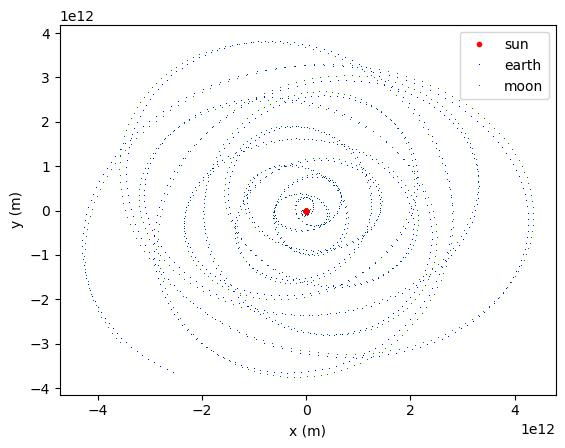

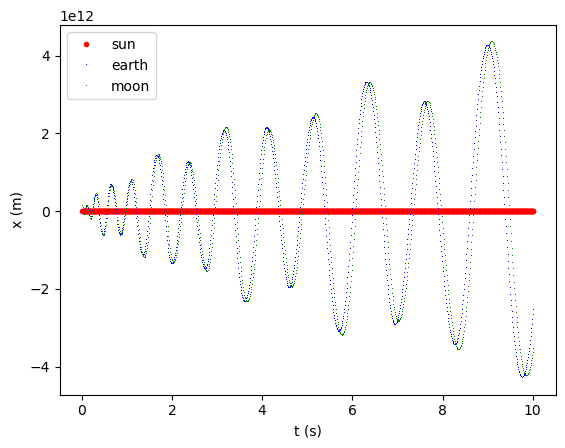

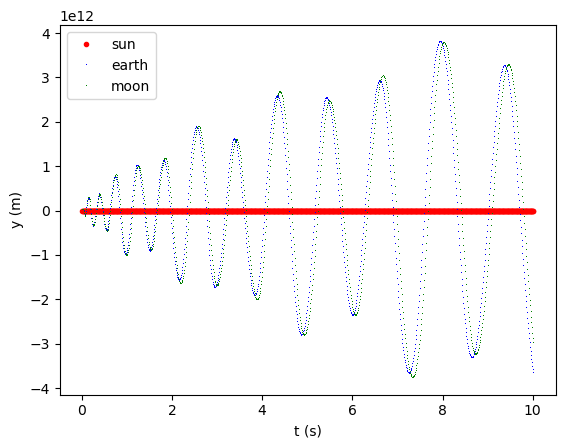

[[52121.82593822832, 211712.88459572577, 497385.15700538736, 723768.0145409179, 754969.1028579063, 674679.4797315297, 517244.915374174, 319086.3012294877, 137545.41807169424, 40501.47553986646, 50549.80354119305, 141508.17411956744, 282850.7568262766, 451404.6578556093, 628709.348458953, 798121.6492531558, 942705.2607836309, 1043742.6965626508, 1080768.5342836918, 1036385.1821532813, 907647.2813320484, 712212.624603468, 478331.3175457329, 231580.7516895837, -9200.651964756951, -230590.12783635873, -422625.6846552213, -577417.2454313652, -688291.0613450708, -749299.4719340589, -755008.1268105628, -700579.8989383935, -582303.5392909993, -398854.1694948588, -153522.59866963606, 143189.44005260256, 472956.34603127325, 813180.2502603192, 1142731.8121686177, 1445561.7147918337, 1710999.0859601458, 1932460.823608795, 2106065.7205201066, 2229632.9467320493, 2302056.595027874, 2322945.272705899, 2292435.4457660606, 2211123.724272788, 2080092.4219369248, 1901023.9221016804, 1676415.2694581263, 1

In [84]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

# Define the gravitational constant
G = 6.67e-11

##############################################################
############## Construct all class objects ###################
##############################################################

class Body:
    def __init__(self, r : np.array, v : np.array, M : float):
        self.r = r
        self.v = v
        self.M = M

class Bodies:
    def __init__(self, bodies):
        """A container for all body elements in a gravitational orbit system dependent on mass and position alone

        Args:
            bodies (list of Body elements): the massive body objects in a list which are in the system to analyze
        """
        self.bodies = bodies
        self.numBodies = len(bodies)
        self.k = np.array([
            [body.r for body in bodies],
            [body.v for body in bodies]
        ], float)
        self.r = self.k[0]
        self.v = self.k[1]
    
    def __len__(self):
        """A function to allow the len() argument to return a valid value

        Returns:
            int: number of bodies in the element
        """
        return len(self.r)
    
    def __iter__(self):
        """Allows an iterable to be called on a Bodies element such as range() or iter()

        Returns:
            iterable: the iterable set of Body elements inside of the Bodies element
        """
        return iter(self.bodies)

class ForceTensor:
    def __init__(self, dimension : int):
        """A class to keep track of and manage the accelerations which each body experiences as a result of anothers' presence

        Args:
            dimension (int): number of dimensions to the problem (i.e. 1, 2, or 3)
        """
        # Define the dimension of the rank-2 tensor and then construct it
        self.dim = dimension
        self.dv = [[0.0 for i in range(self.dim)] for j in range(self.dim)]
        
        # Count the number of unique tensor components
        self.n_components = sum([i for i in range(self.dim)])
    
    def dvTensor(self, bodies : np.array):
        """Computes the dv/dt tensors for each body in the system

        Args:
            bodies (np.array): _description_

        Returns:
            _type_: _description_
        """
        if len(bodies) != self.dim:
            self.dim = len(bodies)
            self.tensor = [[0.0 for i in range(self.dim)] for j in range(self.dim)]
        
        for i, body1 in enumerate(bodies):
            for j, body2 in enumerate(bodies):
                if i == j:
                    self.dv[i][j] = np.array([
                        0.0,
                        0.0
                    ], float)
                else:
                    # Compute gravitational acceleration on M1 by M2
                    self.dv[i][j] = G * body2.M * (body2.r - body1.r) / (norm(body2.r - body1.r) ** 1.5)
        
        return np.array([sum(a) for a in self.dv])

class Orbits:
    def __init__(self, bodies : Bodies):
        """An orbital differential equation solver which acts on a 'Bodies' container to compute time evolution of gravitational states

        Args:
            bodies (Bodies): the bodies object containing all necessary information to find the orbital trjectories of the masses
        """
        self.bodies = bodies
        self.forceTensor = ForceTensor(len(bodies))
        
    def f(self, k : np.array, t : float):
        """A function representing the first and second derivatives for a gravitational field differential equation

        Args:
            k (np.array): an array containing (in this order) the positions, and the velocities of the bodies
            t (float): current time step

        Returns:
            np.array: [dr/dt, dv/dt]
        """
        # Create the derivative function for RK4 method in general for orbiting masses in space
        dr = k[1]
        dv = self.forceTensor.dvTensor(self.bodies)
        return np.array([dr, dv], float)
    
    def Solve(self, t0 : float, tFinal : float, dt : float):
        """A function to solve the orbit differential equation

        Args:
            t0 (float): initial time value
            tFinal (float): when to stop at time tf
            dt (float): time step size

        Returns:
            r, t: these are the plottable outputs of the differential equation r as a function of t
        """
        # Define macros for indeces on the bodies property
        X = 0
        Y = 1
        
        # Set initial time condition
        t = t0
        _t = []
        
        # Make an empty list container to store position values from self.bodies.k
        _r = []
        for i in range(len(bodies)):
            _r.append([[], []])
        
        while t < tFinal:
            # Write the RK4 algorithm to time-step all planets in one move
            k1 = dt * self.f(self.bodies.k, t)
            k2 = dt * self.f(self.bodies.k + k1 / 2, t + dt / 2)
            k3 = dt * self.f(self.bodies.k + k2 / 2, t + dt / 2)
            k4 = dt * self.f(self.bodies.k + k3, t + dt)
            
            # Update the values in the private arrays of the body objects for each mass
            # The reason for this is because the ForceTensor object makes use of those arrays as opposed to the self.bodies.k array
            # thus, the changes have to be made separately
            self.bodies.k += 1 / 6 * (k1 + 2 * (k2 + k3) + k4)
            for index, body in enumerate(self.bodies):
                body.r = self.bodies.k[0][index]
                body.v = self.bodies.k[1][index]
            
            # Save the positions of each planet into the mulitidimensional _r list
            for i in range(len(bodies)):
                _r[i][X].append(bodies.k[0][i][X])
                _r[i][Y].append(bodies.k[0][i][Y])
            
            # Add the time step to t and add t to the list
            t += dt
            _t.append(t)
        
        return _r, _t

##############################################################
############## Set all initial conditions ####################
##############################################################

# Define sun's kinematic parameters
rS = np.array([0.0, 0.0], float)
vS = np.array([0.0, 0.0], float)
MS = 1.99e30

Sun = Body(rS, vS, MS)

# Define earth's kinematic parameters
rE = np.array([1.496e11, 0.0], float)
vE = np.array([-1.0e8, 4.5e11], float)
ME = 5.972e24

Earth = Body(rE, vE, ME)

# Define moon's kinematic parameters
rM = np.array([3.844e8, 0.0]) + rE
vM = np.array([0.0, 1.023e3]) + 1.1 * vE * rM[0] / rE[0]
MM = 7.3e22

Moon = Body(rM, vM, MM)

bodies = Bodies([Sun, Earth, Moon])

##############################################################
################## Build the orbit solver ####################
##############################################################

orbits = Orbits(bodies)

##############################################################
######### Solve the orbiting differential equation ###########
##############################################################

x, t = orbits.Solve(0.0, 10.0, 0.01)

plt.plot(x[0][0], x[0][1], 'r.')
plt.plot(x[1][0], x[1][1], 'b,')
plt.plot(x[2][0], x[2][1], 'g,')
plt.legend(["sun", "earth", "moon"])
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

plt.plot(t, x[0][0], 'r.')
plt.plot(t, x[1][0], 'b,')
plt.plot(t, x[2][0], 'g,')
plt.legend(["sun", "earth", "moon"])
plt.xlabel('t (s)')
plt.ylabel('x (m)')
plt.show()

plt.plot(t, x[0][1], 'r.')
plt.plot(t, x[1][1], 'b,')
plt.plot(t, x[2][1], 'g,')
plt.legend(["sun", "earth", "moon"])
plt.xlabel('t (s)')
plt.ylabel('y (m)')
plt.show()

print(x[0][0:100])

## Conclusion

After much deliberation with this assignment and moving around initial conditions to demonstrate a semi-periodic orbit of the earth and moon around the sun, unphysical speeds were required for the bodies to achieve a regular orbit. This differential equation using RK4 method turned out to be quite troublesome and very sensitive to initial conditions, as expected. Fortunately, a good turnout came about from my code in constructing classes which can be used for any n-body orbit problem, and the RK4 orbit solver is an all-enclosed package which can handle solving the differential equations for future use. To conclude, all that can be said aboout my results is that the RK4 algorithm is implemented properly and the earth and moon successfully orbit the sun in unison for the most part.